# ESP32-C3 Super Mini Sump Pump Alarm System

## Overview

This document describes the implementation of a sump pump alarm system using the **ESP32-C3 Super Mini** microcontroller. The system monitors water levels in a sump pit and alerts the owner through multiple notification channels if the water level rises too high, indicating a potential pump failure.

**Author:** Rob Frohne  
**Last Updated:** November 2025

![ESP32-C3 Super Mini image placeholder - add your photo here]

## Key Features

- **Local Audible Alarm**: Uses an H-Bridge connected to a speaker to produce a loud warning sound
- **Visual Indicator**: Built-in LED blinks during normal operation, stays solid when alarm is triggered
- **Remote Notifications**:
  - Telegram messages to configured chat
  - Email alerts via Gmail SMTP (using App Password)
  - SMS via email-to-SMS gateway (Mint Mobile/T-Mobile)
  - Push notifications via Ntfy.sh (free service)
- **Reliable Operation**: Memory optimized code with garbage collection to prevent crashes
- **Notification Retry**: Attempts to send notifications every 10 minutes if initial attempts fail
- **Power Efficient**: Uses light sleep mode when possible

## Hardware Components

### Required Components

- **[ESP32-C3 Super Mini](https://www.amazon.com/ESP32-C3-Development-Board-low-Power-Compatible/dp/B09GK74F7N/)** microcontroller
- **[L9110S H-Bridge module](https://www.amazon.com/HiLetgo-L9110S-Stepper-Driver-Controller/dp/B01ACIALJ4/)** for speaker control
- **Speaker** (8 ohm, 0.5W or greater recommended for volume)
- **Water level sensor** (float switch, (open for alarm))
- **Resistor** (10KΩ pull-up - optional if not using internal pull-up)
- **Power supply** (5V USB adapter or battery pack)
- **Wires** and **connectors**
- **Project enclosure** (waterproof recommended)

### Optional Components
- **Backup battery** with voltage regulator
- **Float switch** (as an alternative water detection method)
- **USB to Serial adapter** (for programming and debugging)

![Hardware components placeholder - add your photo here]

## ESP32-C3 Super Mini Pinout

The ESP32-C3 Super Mini has 22 pins available for use. Here is the pinout diagram:

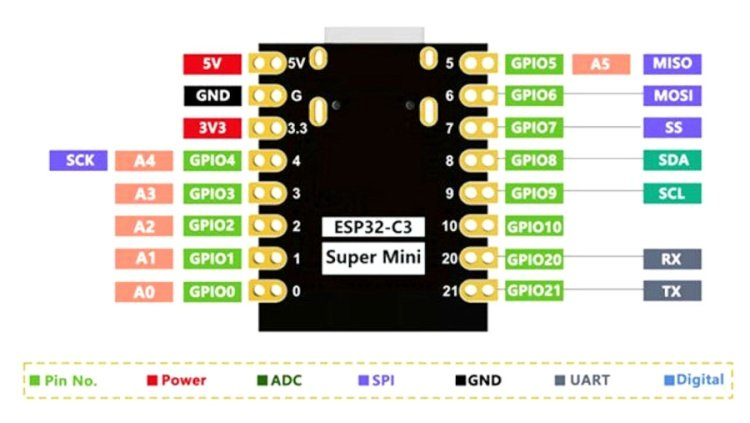
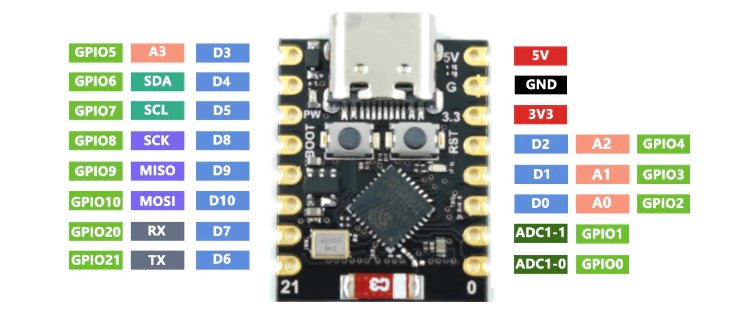

### Pin Connections for Sump Alarm

| GPIO Pin | Function               | Description                                    |
|----------|------------------------|------------------------------------------------|
| 3        | Sensor Virtual GND     | Set LOW to act as GND for float switch         |
| 4        | Water Sensor Input     | Float switch input with internal pull-up       |
| 6        | H-Bridge Input A       | Speaker control                                |
| 7        | H-Bridge Input B       | Speaker control                                |
| 8        | Built-in LED           | Status indicator                               |
| 3V3      | Power                  | Powers H-Bridge (if 3.3V compatible)           |
| GND      | Ground                 | Common ground for H-Bridge                     |

**Note:** GPIO3 is used as a \"virtual GND\" for the float switch to avoid splicing ground wires. This works because the float switch draws essentially zero current.

### Float Switch Logic

The float switch is **normally closed** (NC) when water is low, and **opens** when water rises:
- **No water (switch closed):** GPIO4 is pulled LOW through GPIO3 → reads 0
- **Water HIGH (switch open):** GPIO4 is pulled HIGH by internal pull-up → reads 1

### Circuit Diagram

```
ESP32-C3 Super Mini                     L9110S H-Bridge                Speaker
+---------------+                      +------------+                  +-----+
|               |                      |            |                  |     |
| GPIO 6 (IN_A) |--------------------->| IA         |                  |     |
|               |                      |            |                  |     |
| GPIO 7 (IN_B) |--------------------->| IB        A+|---------------->|     |
|               |                      |            |                  |     |
| 3V3           |--------------------->| VCC       A-|---------------->|     |
|               |                      |            |                  |     |
| GND           |--------------------->| GND        |                  |     |
+---------------+                      +------------+                  +-----+

                                       Float Switch
+---------------+                      +-----------+
|               |                      |           |
| GPIO 3 (GND)  |--------------------->| Terminal 1|
|  (set LOW)    |                      |   (NC)    |
|               |                      |           |
| GPIO 4 (IN)   |<---------------------| Terminal 2|
|  (pull-up)    |                      |           |
+---------------+                      +-----------+
```

[Space for your actual schematic diagram]

## Software Architecture

The system is built on MicroPython and includes the following key components:

### Core Modules

1. **Water Detection**: Continuously monitors water sensor input
2. **Alarm Controller**: Manages speaker and LED outputs
3. **Notification System**: Handles WiFi connectivity and notification delivery
4. **Memory Management**: Optimizes memory usage for reliability

### Program Flow

```
                       +-----------------+
                       |  Initialization |
                       +--------+--------+
                                |
                                v
                       +--------+--------+
                       |  Monitor Water  |<-------+
                       |     Level       |        |
                       +--------+--------+        |
                                |                 |
                                v                 |
                       +--------+--------+        |
                   No  |                 |        |
              +--------+  Water Detected?|        |
              |        |                 |        |
              |        +--------+--------+        |
              |                 | Yes             |
              v                 v                 |
    +-------------------+   +---+-------------+   |
    | - LED Blinking    |   | - LED Solid On  |   |
    | - Speaker Off     |   | - Speaker On    |   |
    | - Reset Counters  |   | - Send Alerts   |   |
    +--------+----------+   +-------+---------+   |
             |                      |             |
             +----------------------+-------------+
```

### Notification System

The system uses multiple notification channels to ensure alerts are received:

1. **Telegram Bot API**:
   - Sends instant messages to a configured Telegram chat
   - Implements retry logic with increasing delays
   - Optimized HTTP requests to work within ESP32-C3 memory constraints

2. **Email via Gmail SMTP**:
   - Uses Gmail's SMTP server with App Password authentication
   - Sends emails directly from your own Gmail account
   - Supports multiple recipients
   - No subscription fees or third-party services needed

## Setting Up Your System

### 1. Preparing the ESP32-C3

1. **Install MicroPython**:
   - Download the latest ESP32-C3 MicroPython firmware from [micropython.org](https://micropython.org/download/esp32c3/)
   - Flash the firmware using esptool:
     ```bash
     pip install esptool
     esptool.py --port /dev/ttyUSB0 erase_flash
     esptool.py --port /dev/ttyUSB0 --baud 460800 write_flash -z 0x0 esp32c3-20220117-v1.18.bin
     ```

2. **Connect to Serial Console**:
   - Use screen, picocom, or other serial terminal:
     ```bash
     picocom -b 115200 /dev/ttyUSB0
     ```

### 2. Upload the Code

1. **Using tools like ampy, rshell, or mpremote**:
   ```bash
   pip install adafruit-ampy
   ampy --port /dev/ttyUSB0 put main.py
   ```
   
   Or with mpremote (newer tool):
   ```bash
   pip install mpremote
   mpremote cp main.py :
   ```

2. **Using Thonny IDE**:
   - Connect to your ESP32-C3
   - Open main.py file
   - Save to the device (not local)

### 3. Configure Settings

Update the following sections in main.py:

#### WiFi Configuration
```python
connect_wifi("YOUR_WIFI_SSID", "YOUR_WIFI_PASSWORD")
```

#### Telegram Settings
```python
bot_token = "YOUR_BOT_TOKEN"
chat_id = "YOUR_CHAT_ID"
```

## Setting Up Gmail for Notifications

To use Gmail for sending email notifications, you'll need to set up an App Password:

### Creating a Gmail App Password

1. **Enable 2-Factor Authentication**:
   - Go to your Google Account settings
   - Select "Security"
   - Enable "2-Step Verification" if not already enabled

2. **Generate an App Password**:
   - Go to [https://myaccount.google.com/apppasswords](https://myaccount.google.com/apppasswords)
   - Select "App" dropdown and choose "Other (Custom name)"
   - Enter "ESP32 Sump Alarm" and click "Generate"
   - You'll receive a 16-character password - **save this password as you won't be able to see it again**

3. **Configure your credentials in the code**:
   ```python
   # Gmail credentials - replace with your own
   gmail_user = "your_email@gmail.com"
   app_password = "16-character-app-password"
   ```

### How Gmail SMTP Works in the Code

The system uses a custom `email_sender.py` module that implements:

1. **SSL Socket Connection**: Securely connects to Gmail's SMTP server
2. **SMTP Protocol Implementation**: Handles the email transmission protocol
3. **Base64 Authentication**: Properly encodes credentials for Gmail's requirements
4. **Error Handling**: Manages connection issues and provides detailed feedback

This direct implementation avoids the need for external services or subscriptions.

## Testing Your Gmail Integration

Before deploying your sump alarm system, it's important to test the Gmail integration separately:

### 1. Testing Gmail Connection

Upload this test script to your ESP32-C3:

```python
# test_gmail.py - Simple test for Gmail SMTP connection
import network
import time
from email_sender import GmailSender

def test_gmail():
    # Connect to WiFi
    wlan = network.WLAN(network.STA_IF)
    wlan.active(True)
    wlan.connect("YOUR_WIFI_SSID", "YOUR_WIFI_PASSWORD")
    
    # Wait for connection with timeout
    max_wait = 20
    while max_wait > 0:
        if wlan.isconnected():
            break
        max_wait -= 1
        print("Waiting for connection...")
        time.sleep(1)
    
    if not wlan.isconnected():
        print("WiFi connection failed!")
        return
    
    print("WiFi connected at", wlan.ifconfig()[0])
    
    # Send test email via Gmail SMTP
    gmail_user = "your_email@gmail.com"
    app_password = "your-app-password"
    
    try:
        print("Initializing Gmail sender...")
        gmail = GmailSender(gmail_user, app_password)
        
        subject = "ESP32-C3 Sump Alarm Test"
        message = "This is a test email from your ESP32-C3 Sump Alarm system."
        recipient = "your_email@gmail.com"
        
        print("Sending test email...")
        success = gmail.send_email(recipient, subject, message)
        
        if success:
            print("Test email sent successfully!")
        else:
            print("Failed to send test email")
    except Exception as e:
        print("Error:", e)

test_gmail()
```

### 2. Running the Test

1. Upload both `email_sender.py` and `test_gmail.py` to your ESP32-C3
2. Run the test using:
   ```
   >>> import test_gmail
   ```
3. You should receive a test email at your specified address

### 3. Common Issues and Solutions

- **Authentication Failed**: Double-check your App Password is entered correctly
- **Connection Timeout**: Ensure your WiFi network allows outbound connections on port 465
- **Memory Errors**: Free memory with `gc.collect()` before email operations
- **SSL Handshake Errors**: Make sure your ESP32-C3 firmware is up to date